## Import libs

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

from benchmark.models.zhang.learning import *
from benchmark.models.zhang.models import FairLogisticRegression
from benchmark.util.load_data import load_data
from benchmark.util.evaluation import *

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)

## Load data

In [3]:
data_name = 'adult-race'

In [4]:
x_train, y_train, a_train = load_data(data_name, 'train')
raw_data = (x_train, y_train, a_train)

In [5]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]

In [6]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data

<BatchDataset shapes: ((64, 112), (64, 1), (64, 5)), types: (tf.float64, tf.float64, tf.float64)>

In [7]:
x_valid, y_valid, a_valid = load_data(data_name, 'valid')

valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size, drop_remainder=True)

In [8]:
x_test, y_test, a_test = load_data(data_name, 'test')

test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size, drop_remainder=True)

## Testing if models are being trained

### For DP

In [9]:
fairdef='DemPar'
model = FairLogisticRegression(xdim, ydim, adim, batch_size, fairdef)

ret = train_loop(model, raw_data, train_data, 1)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5199112296104431 | 1.3905614614486694 | 0.6526856763925729 | -0.0019756742118208098


In [10]:
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Class Acc | Adv Acc
> 0.7883976063829787 | 0.0007221952397772347
> DP | DEqOdds | DEqOpp
> 0.4118994325399399 | 0.8430719019379467 | 0.8262129202485085
> Confusion Matrix 
TN: 3646.0 | FP: 912.0 
FN: 361.0 | TP: 1097.0


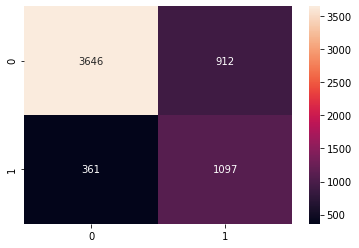

In [11]:
sns.heatmap(ret[4], annot=True, fmt='g')

### For EqOdds

In [12]:
fairdef='EqOdds'
model = FairLogisticRegression(xdim, ydim, adim, batch_size, fairdef)
ret = train_loop(model, raw_data, train_data, 1)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6225697994232178 | 0.9331574440002441 | 0.5320374668435013 | 0.016757749277969886


In [13]:
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Class Acc | Adv Acc
> 0.5568484042553192 | 0.2513870888567985
> DP | DEqOdds | DEqOpp
> 0.49705928564071655 | 0.7583927632076666 | 0.9271326416637748
> Confusion Matrix 
TN: 1925.0 | FP: 2633.0 
FN: 33.0 | TP: 1425.0


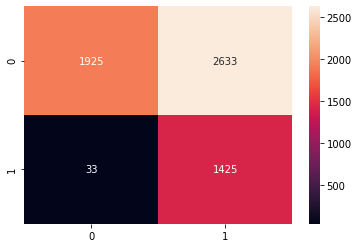

In [14]:
sns.heatmap(ret[4], annot=True, fmt='g')

### For EqOpp

In [15]:
fairdef='EqOpp'
model = FairLogisticRegression(xdim, ydim, adim, batch_size, fairdef)
ret = train_loop(model, raw_data, train_data, 1)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5086170434951782 | 0.4394846558570862 | 0.6637516578249337 | -0.0019756742118208098


In [16]:
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Class Acc | Adv Acc
> 0.8261303191489362 | 0.001220865452543185
> DP | DEqOdds | DEqOpp
> 0.39535266160964966 | 0.8422214005840942 | 0.7746073603630066
> Confusion Matrix 
TN: 4169.0 | FP: 389.0 
FN: 657.0 | TP: 801.0


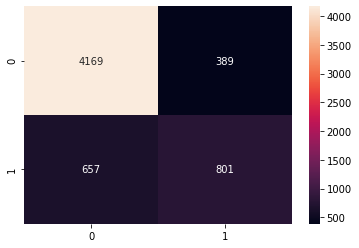

In [17]:
sns.heatmap(ret[4], annot=True, fmt='g')

## Models

In [18]:
cmap = sns.light_palette("seagreen", as_cmap=True)

In [19]:
#For DemPar
fairdef = 'DemPar'
model = FairLogisticRegression(xdim, ydim, adim, batch_size, fairdef)
train_loop(model, raw_data, train_data, epochs)
print('Validation')
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret4dp = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5199112296104431 | 1.3905614614486694 | 0.6526856763925729 | -0.0019756742118208098
> 2 | 0.4651602506637573 | 1.3244471549987793 | 0.8174320291777188 | -0.0019756742118208098
> 3 | 0.45281606912612915 | 1.2735588550567627 | 0.8231929708222812 | -0.0017684457789049225
> 4 | 0.4489431381225586 | 1.2328276634216309 | 0.8263428381962865 | 0.013483541871887935
> 5 | 0.4476257264614105 | 1.2011950016021729 | 0.8281664456233422 | 0.054473264305914114
> 6 | 0.4468083083629608 | 1.1805096864700317 | 0.8292854774535809 | 0.08825144669737676
> 7 | 0.4463529884815216 | 1.163445234298706 | 0.8304045092838196 | 0.11104653953557306
> 8 | 0.44614923000335693 | 1.1491590738296509 | 0.8310676392572944 | 0.12832936478546506
> 9 | 0.4460941255092621 | 1.136975646018982 | 0.8318136604774535 | 0.14329123481199027
> 10 | 0.4461246728897095 | 1.1264221668243408 | 0.832145225464191 | 0.15369408611277371
Validation
> Class Acc | Adv Acc
> 0.83510638

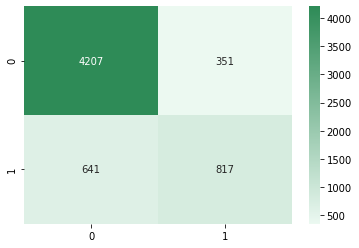

In [20]:
sns.heatmap(ret4dp[4], cmap=cmap, annot=True, fmt='g')

In [21]:
#For EqOdds
fairdef = 'EqOdds'
model = FairLogisticRegression(xdim, ydim, adim, batch_size, fairdef)
train_loop(model, raw_data, train_data, epochs)
print('Validation')
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret4eqodds = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6225697994232178 | 0.9331574440002441 | 0.5320374668435013 | 0.016757749277969886
> 2 | 0.5248477458953857 | 0.9030101895332336 | 0.6981929708222812 | 0.3159537015764403
> 3 | 0.4760250151157379 | 0.9513474702835083 | 0.7783902519893899 | 0.34782538568941923
> 4 | 0.4577804207801819 | 0.9723141193389893 | 0.8090600132625995 | 0.3270611283949895
> 5 | 0.4505801200866699 | 0.9785846471786499 | 0.8208720159151194 | 0.31902067746660756
> 6 | 0.44748982787132263 | 0.9786810874938965 | 0.8256797082228117 | 0.3164510489774952
> 7 | 0.4461158514022827 | 0.9761068820953369 | 0.8273375331564987 | 0.3170727333276278
> 8 | 0.44553661346435547 | 0.9722491502761841 | 0.8282493368700266 | 0.3191035687132919
> 9 | 0.4453478455543518 | 0.9677159786224365 | 0.8287881299734748 | 0.3208857305170054
> 10 | 0.44535866379737854 | 0.9628064036369324 | 0.830238726790451 | 0.3240770435143529
Validation
> Class Acc | Adv Acc
> 0.8304521276595744 | 0.3

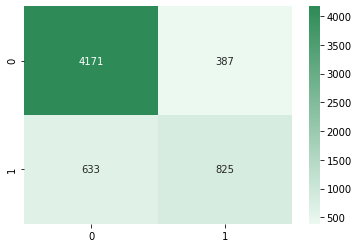

In [22]:
sns.heatmap(ret4eqodds[4], cmap=cmap, annot=True, fmt='g')

In [23]:
#For EqOpp
fairdef = 'EqOpp'
model = FairLogisticRegression(xdim, ydim, adim, batch_size, fairdef)
train_loop(model, raw_data, train_data, epochs)
print('Validation')
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret4eqopp = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5086170434951782 | 0.4394846558570862 | 0.6637516578249337 | -0.0019756742118208098
> 2 | 0.4683226943016052 | 0.36097967624664307 | 0.8222397214854111 | 0.0548048289764465
> 3 | 0.4601186215877533 | 0.32333970069885254 | 0.8258454907161804 | 0.11195834324910091
> 4 | 0.4578568935394287 | 0.3023611009120941 | 0.8277934350132626 | 0.13156212324805222
> 5 | 0.4571680426597595 | 0.2889596223831177 | 0.8293683687002652 | 0.14710423200136788
> 6 | 0.45700347423553467 | 0.2795723080635071 | 0.8303630636604774 | 0.1576728659536225
> 7 | 0.4570300579071045 | 0.27255183458328247 | 0.831440649867374 | 0.16687379433558538
> 8 | 0.45712941884994507 | 0.2670389413833618 | 0.8319794429708223 | 0.17304919221356946
> 9 | 0.4572538733482361 | 0.2625439167022705 | 0.8322695623342176 | 0.17835423200136788
> 10 | 0.45738327503204346 | 0.2587689757347107 | 0.8325182360742706 | 0.18274746807563844
Validation
> Class Acc | Adv Acc
> 0.835272606382

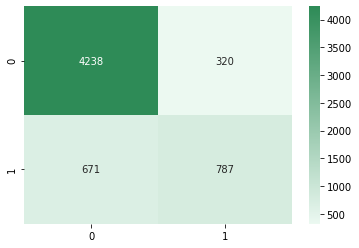

In [24]:
sns.heatmap(ret4eqopp[4], cmap=cmap, annot=True, fmt='g')

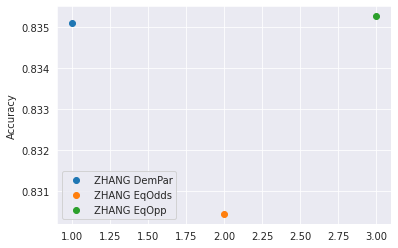

In [25]:
#x=[1,2,3]
#y = [tf.math.reduce_mean(ret4dp[0]),tf.math.reduce_mean(ret4eqodds[0]),tf.math.reduce_mean(ret4eqodds[0])]
y=[2,4,6]
#plt.scatter()
#plt.pyplot.grid(b=True, color='darkgrey')
sns.set_style('darkgrid')
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
#plt.scatter(x, y)

plt.scatter(1, ret4dp[0], label = "ZHANG DemPar")

plt.scatter(2, ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(3, ret4eqopp[0], label = "ZHANG EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()

plt.show()

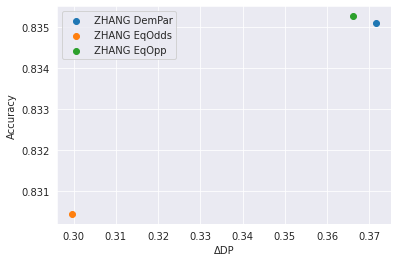

In [26]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''
#axes = plt.gca()
#axes.set_xlim([0.0643,0.0645])
plt.scatter(ret4dp[1], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[1], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

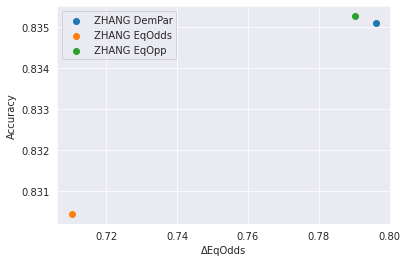

In [27]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[2], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[2], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

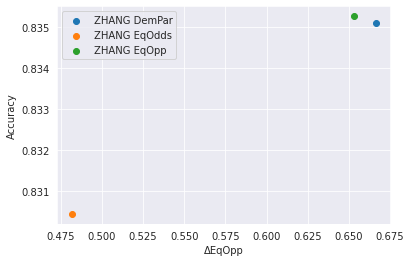

In [28]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[3], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[3], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()